**데이터 불러오기**

In [ ]:
import pandas as pd
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import defaultdict

file_path = '/content/drive/MyDrive/기학팀플/processed_movie_data.csv'
data = pd.read_csv(file_path)

**TF-IDF 벡터라이저 초기화 및 리뷰 데이터 학습**



In [ ]:
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['review_content'])
feature_names = vectorizer.get_feature_names_out()

**각 키워드의 평균 TF-IDF 점수 계산**

In [ ]:
tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0]
keyword_scores = dict(zip(feature_names, tfidf_scores))

**주요 키워드와 점수를 내림차순으로 정렬/ 결과 출력 시각화**

In [ ]:
sorted_keywords = sorted(keyword_scores.items(), key=lambda item: item[1], reverse=True)

print("Top Keywords and Their TF-IDF Scores:")
for keyword, score in sorted_keywords[:100]:  # 상위 100개 키워드 출력
    print(f"{keyword}: {score:.4f}")

Top Keywords and Their TF-IDF Scores:
film: 0.0782
movie: 0.0602
like: 0.0354
story: 0.0310
just: 0.0261
good: 0.0237
comedy: 0.0221
time: 0.0207
best: 0.0196
director: 0.0189
make: 0.0175
way: 0.0170
action: 0.0168
little: 0.0168
characters: 0.0165
funny: 0.0162
fun: 0.0157
doesn: 0.0156
life: 0.0155
drama: 0.0154
great: 0.0154
makes: 0.0147
performance: 0.0142
work: 0.0137
thriller: 0.0136
films: 0.0135
movies: 0.0133
love: 0.0131
performances: 0.0130
does: 0.0130
better: 0.0130
new: 0.0124
isn: 0.0122
character: 0.0122
entertaining: 0.0119
world: 0.0119
man: 0.0118
cast: 0.0115
really: 0.0115
horror: 0.0113
feels: 0.0110
bad: 0.0107
plot: 0.0106
tale: 0.0105
real: 0.0105
long: 0.0102
don: 0.0101
year: 0.0100
big: 0.0099
people: 0.0098
end: 0.0098
old: 0.0098
look: 0.0097
script: 0.0094
feel: 0.0094
far: 0.0093
moments: 0.0093
hard: 0.0092
quite: 0.0092
original: 0.0091
heart: 0.0090
audience: 0.0090
family: 0.0090
sense: 0.0089
right: 0.0088
screen: 0.0086
kind: 0.0085
genre: 0.0084

**결과 출력 시각화**

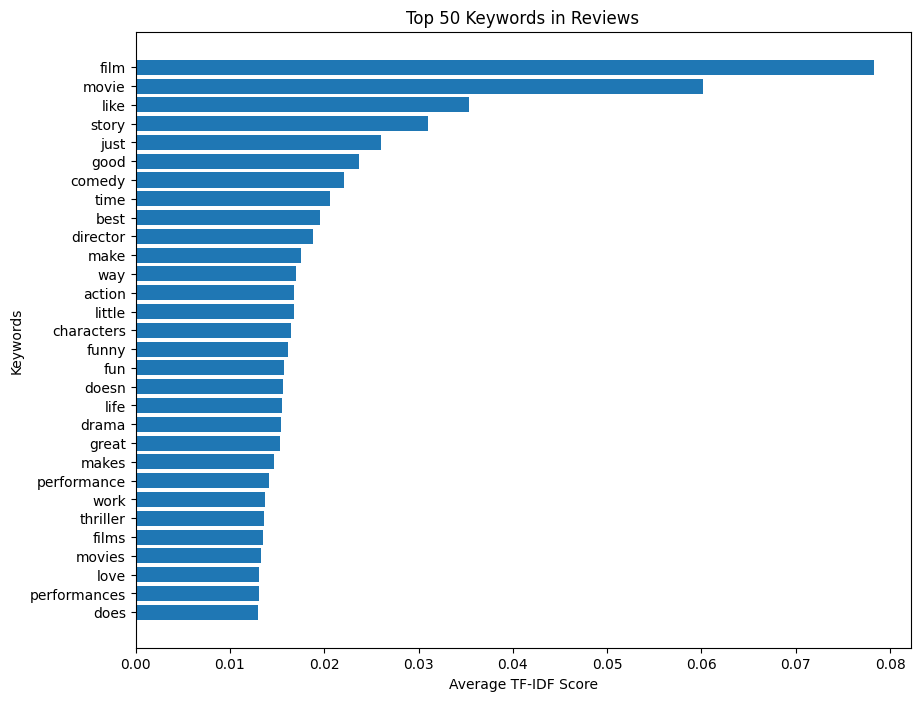

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh([k for k, v in sorted_keywords[:30]], [v for k, v in sorted_keywords[:30]])
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 50 Keywords in Reviews')
plt.gca().invert_yaxis()  # 상위 키워드를 위로
plt.show()

**워드 클라우드**

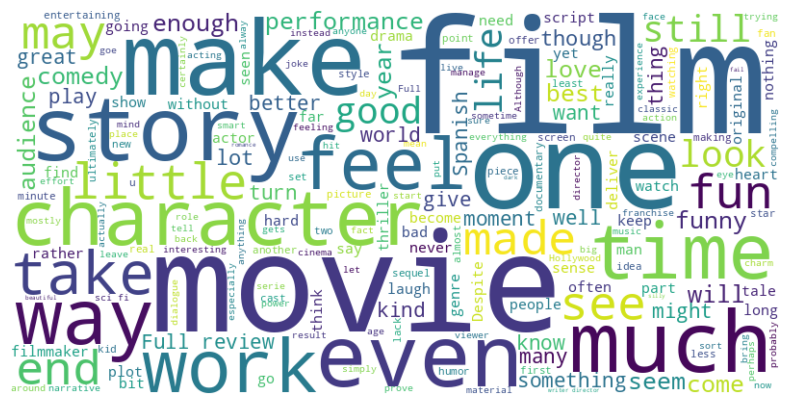

In [ ]:
from wordcloud import WordCloud
text = " ".join(review for review in data['review_content'])

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 리뷰 데이터 감성 분석

**BERT을 사용한 감정 분석 모델**

In [ ]:
!pip install datasets

**학습 데이터 로드/ 데이터 읽기**

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch


# 데이터 로드
train_path = '/content/drive/MyDrive/기학팀플/NLP_train.txt'
val_path = '/content/drive/MyDrive/기학팀플/NLP_val.txt'
test_path = '/content/drive/MyDrive/기학팀플/NLP_test.txt'
tweet_emotions_path = '/content/drive/MyDrive/기학팀플/tweet_emotions.csv'
movie_reviews_path = '/content/drive/MyDrive/기학팀플/processed_movie_data.csv'  # 영화 리뷰 데이터 경로

# 데이터 읽기
train_data = pd.read_csv(train_path, sep=';', names=['content', 'sentiment'])
val_data = pd.read_csv(val_path, sep=';', names=['content', 'sentiment'])
test_data = pd.read_csv(test_path, sep=';', names=['content', 'sentiment'])
tweet_data = pd.read_csv(tweet_emotions_path)
movie_reviews = pd.read_csv(movie_reviews_path)

**텍스트 전처리**

In [ ]:
# 텍스트 전처리 함수 정의
def preprocess_text(text):
    text = text.lower()  # 소문자 변환
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # URL 제거
    text = re.sub(r'\@\w+|\#', '', text)  # @ 및 # 제거
    text = re.sub(r'[^A-Za-z\s]', '', text)  # 알파벳과 공백 제외 모든 문자 제거
    text = re.sub(r'\s+', ' ', text).strip()  # 여분의 공백 제거
    return text

train_data = train_data.drop_duplicates()
val_data = val_data.drop_duplicates()
test_data = test_data.drop_duplicates()
tweet_data = tweet_data.drop_duplicates()

train_data['content'] = train_data['content'].apply(preprocess_text)
val_data['content'] = val_data['content'].apply(preprocess_text)
test_data['content'] = test_data['content'].apply(preprocess_text)
tweet_data['content'] = tweet_data['content'].apply(preprocess_text)
movie_reviews['review_text'] = movie_reviews['review_content'].apply(preprocess_text)

# 데이터 병합
expanded_train_data = pd.concat([train_data, tweet_data], ignore_index=True)

**TF-IDF + Logistic Regression으로 감정 열 추가(실행 안함)**

**BERT 모델로 감정 열 추가 (정밀 분석)**


In [ ]:
# 데이터 결합 및 레이블 매핑
all_data = pd.concat([train_data, val_data, test_data, tweet_data], ignore_index=True)
label_mapping = {label: idx for idx, label in enumerate(all_data['sentiment'].unique())}
all_data['label'] = all_data['sentiment'].map(label_mapping)

# 데이터셋 변환
train_dataset = Dataset.from_pandas(all_data)
movie_reviews = movie_reviews.rename(columns={"review_text": "content"})
movie_dataset = Dataset.from_pandas(movie_reviews)

# BERT 모델 및 토크나이저 설정
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_mapping)
)

# 토큰화 함수
def tokenize_function(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True)

# 데이터셋 토큰화
train_dataset = train_dataset.map(tokenize_function, batched=True)
movie_dataset = movie_dataset.map(tokenize_function, batched=True)

# 포맷 설정
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
movie_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/59999 [00:00<?, ? examples/s]

Map:   0%|          | 0/676581 [00:00<?, ? examples/s]

In [ ]:
val_data['label'] = val_data['sentiment'].map(label_mapping)

val_dataset = Dataset.from_pandas(val_data)

# 토큰화
val_dataset = val_dataset.map(tokenize_function, batched=True)

# PyTorch 텐서로 변환
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# 학습 설정
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs"
)

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
     eval_dataset=val_dataset,
    train_dataset=train_dataset
)

# 모델 학습
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,1.290300,0.138019
2,1.173200,0.078832
3,1.017600,0.064134


TrainOutput(global_step=11250, training_loss=1.2126382120768229, metrics={'train_runtime': 4590.7489, 'train_samples_per_second': 39.209, 'train_steps_per_second': 2.451, 'total_flos': 4.736472848062157e+16, 'train_loss': 1.2126382120768229, 'epoch': 3.0})

**배치처리로 감정 예측**

In [ ]:
from torch.utils.data import DataLoader

# DataLoader 생성
batch_size = 32  # 배치 크기 설정
movie_dataloader = DataLoader(movie_dataset, batch_size=batch_size)

# 예측 함수
def predict_emotions(dataloader):
    predictions = []
    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():  # 그래디언트를 계산하지 않음
        for batch in dataloader:
            # 필요한 입력값을 CUDA로 이동
            inputs = {key: batch[key].to("cuda") for key in ["input_ids", "attention_mask"]}
            outputs = model(**inputs)  # 모델에 입력
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)  # 확률 계산
            batch_predictions = probs.argmax(dim=-1).cpu().numpy()  # 가장 높은 확률의 클래스 반환
            predictions.extend(batch_predictions)
    return predictions
# 배치 단위 예측
predictions = predict_emotions(movie_dataloader)

# 감정 레이블 매핑
movie_reviews['predicted_emotion'] = [list(label_mapping.keys())[pred] for pred in predictions]


**감정 데이터 집계 및 시각화**

In [ ]:
import matplotlib.pyplot as plt

# 감정 데이터 빈도 계산
emotion_counts = movie_reviews['predicted_emotion'].value_counts()

# 감정 데이터 출력
print("감정별 빈도:\n", emotion_counts)

감정별 빈도:
 predicted_emotion
neutral      178952
happiness    113249
worry         93906
sadness       88282
love          58912
surprise      43288
joy           32512
fun           26126
hate          17924
anger         12128
relief         5840
fear           5453
empty             7
boredom           2
Name: count, dtype: int64


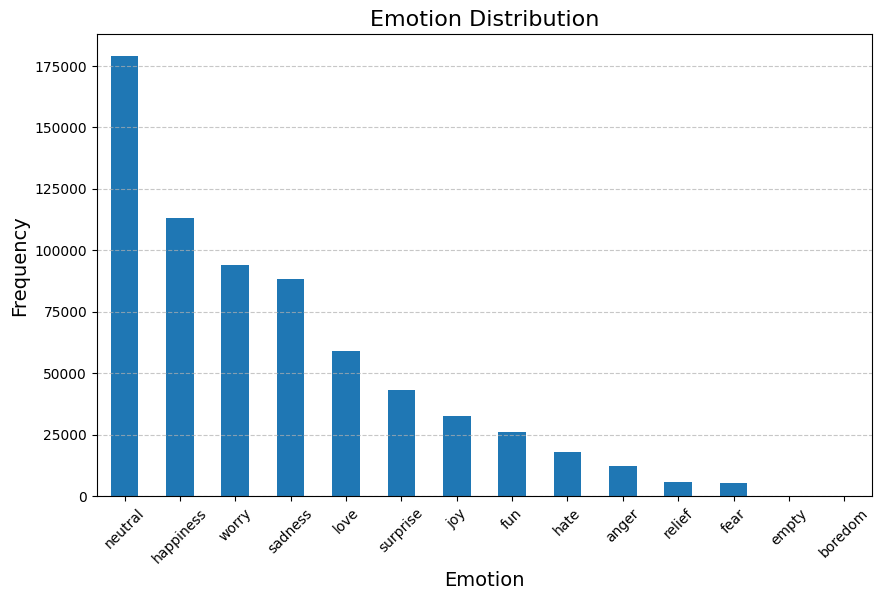

In [23]:
# Bar chart visualization
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title("Emotion Distribution", fontsize=16)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


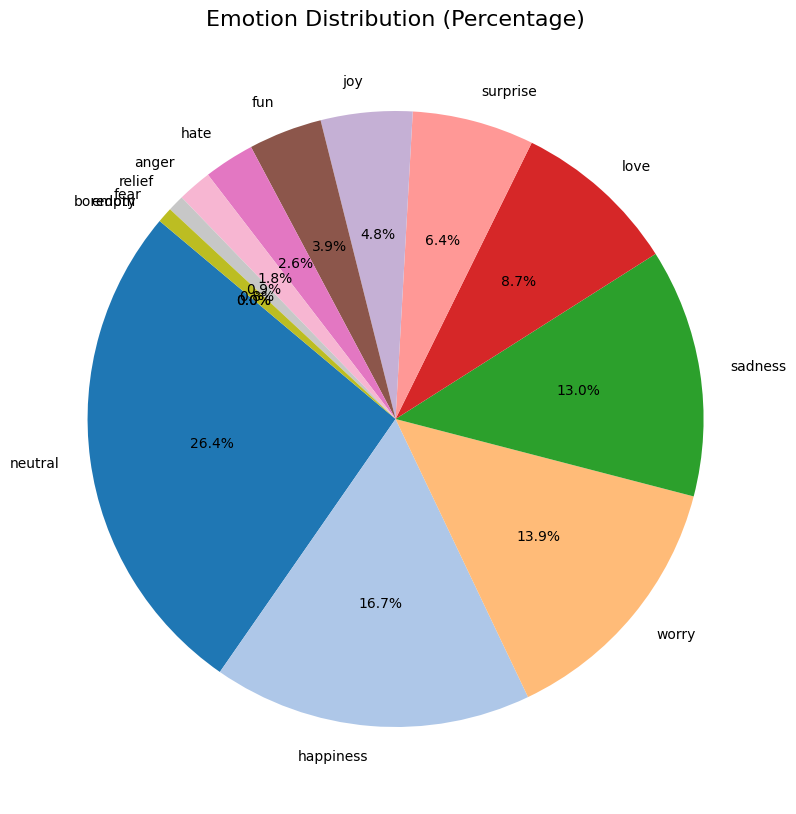

In [25]:
# Pie chart visualization
plt.figure(figsize=(10, 10))
emotion_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title("Emotion Distribution (Percentage)", fontsize=16)
plt.ylabel('')  # Remove y-axis label
plt.show()

**감정 워드 클라우드**

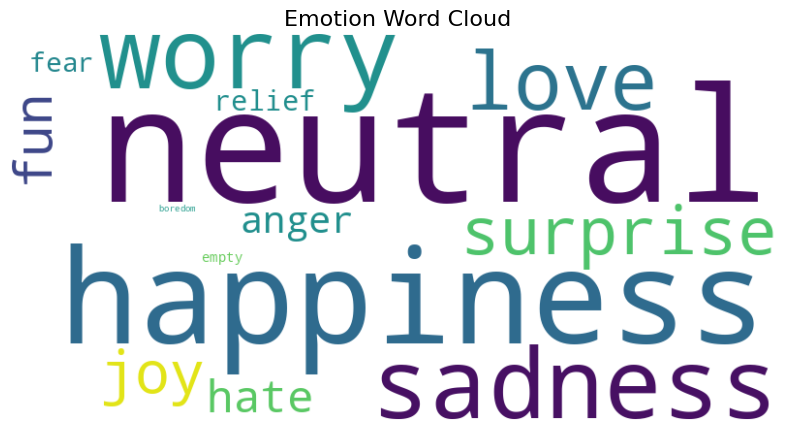

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 감정별 빈도 계산
emotion_counts = movie_reviews['predicted_emotion'].value_counts()

# 워드 클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(emotion_counts)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Emotion Word Cloud", fontsize=16)
plt.show()

In [ ]:
movie_reviews.head()

,critic_name,top_critic,review_type,review_content,movie_title,authors,actors,original_release_date,runtime,tomatometer_rating,...,production_company_category,directors_category,movie_info_keyword,author_id,actor_id,actors_split,actor_ids,movie_id,authors_split,predicted_emotion
0,Ben McEachen,0,1,Whether audiences will get behind The Lightnin...,Percy Jackson & the Olympians: The Lightning T...,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,119.0,0.49,...,1,1,life war mother son gets,0,0,"['Logan Lerman', 'Brandon T. Jackson', 'Alexan...","[76058, 130933, 53933, 107930, 33787, 182302, ...",9737,"['Craig Titley', 'Chris Columbus', 'Rick Riord...",worry
1,Nick Schager,0,0,Harry Potter knockoffs don't come more transpa...,Percy Jackson & the Olympians: The Lightning T...,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,119.0,0.49,...,1,1,life war mother son gets,0,0,"['Logan Lerman', 'Brandon T. Jackson', 'Alexan...","[76058, 130933, 53933, 107930, 33787, 182302, ...",9737,"['Craig Titley', 'Chris Columbus', 'Rick Riord...",neutral
2,Bill Goodykoontz,1,1,"Percy Jackson isn't a great movie, but it's a ...",Percy Jackson & the Olympians: The Lightning T...,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,119.0,0.49,...,1,1,life war mother son gets,0,0,"['Logan Lerman', 'Brandon T. Jackson', 'Alexan...","[76058, 130933, 53933, 107930, 33787, 182302, ...",9737,"['Craig Titley', 'Chris Columbus', 'Rick Riord...",neutral
3,Jordan Hoffman,0,1,"Fun, brisk and imaginative",Percy Jackson & the Olympians: The Lightning T...,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,119.0,0.49,...,1,1,life war mother son gets,0,0,"['Logan Lerman', 'Brandon T. Jackson', 'Alexan...","[76058, 130933, 53933, 107930, 33787, 182302, ...",9737,"['Craig Titley', 'Chris Columbus', 'Rick Riord...",happiness
4,Jim Schembri,1,1,"Crammed with dragons, set-destroying fights an...",Percy Jackson & the Olympians: The Lightning T...,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,119.0,0.49,...,1,1,life war mother son gets,0,0,"['Logan Lerman', 'Brandon T. Jackson', 'Alexan...","[76058, 130933, 53933, 107930, 33787, 182302, ...",9737,"['Craig Titley', 'Chris Columbus', 'Rick Riord...",worry


In [ ]:
movie_reviews = movie_reviews.drop(columns=["content"])

**CSV 저장**

In [ ]:
movie_reviews.to_csv('/content/drive/MyDrive/기학팀플/movie_data.csv', index=False)
print("영화 리뷰 데이터에 감정 열이 추가되었습니다. 저장된 파일: movie_reviews_with_emotions.csv")

영화 리뷰 데이터에 감정 열이 추가되었습니다. 저장된 파일: movie_reviews_with_emotions.csv


**키워드로** 분석하기
* Heartwarming (따뜻한): 긍정적인 감정 점수가 높고, 주관성이 강한 경우.
* Touching (감동적인): 약간 긍정적이면서 주관성이 강한 경우.
* Excited (흥분한): 매우 긍정적이고 강한 감정.
* Happy (행복한): 긍정적이지만 주관성이 중간 정도일 경우.
* Neutral (중립적인): 감정 점수가 0인 경우.
* Angry (분노): 매우 부정적이고 주관성이 강한 경우.
* Frustrated (좌절): 매우 부정적이지만 주관성이 낮은 경우.
* Sad (슬픈): 부정적이면서 중간 주관성.
* Melancholic(우울한): 약간 부정적이고 주관성이 강한 경우.
* Scary (무서운): 공포와 관련된 키워드와 부정적인 감정 점수.
* Humanistic (인간미 있는): 따뜻함과 연민을 나타내는 단어와 긍정적 감정 점수.
* Childlike (유아틱한): 간단하고 귀여운 표현이 포함된 경우.
* Romantic (로맨틱한): 사랑과 관련된 키워드와 긍정적인 감정 점수.
* Funny (웃긴): 유머와 관련된 키워드와 긍정적 또는 중립적 감정 점수
* Hopeful (희망적인)
* Nostalgic (향수를 불러일으키는)
* Confused (혼란스러운)
* Inspired (영감을 받은)
* Regretful (후회하는)
* Overwhelmed (압도된)
* Lonely (외로운)
* Curious (호기심 많은)
*Tense (긴장한)
* Grateful (감사하는)
* Peaceful (평온한)
* Empathetic (공감하는)
* Sarcastic (비꼬는)

In [ ]:
from textblob import TextBlob
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from afinn import Afinn
from collections import Counter
import nltk

# NLTK 데이터 다운로드
nltk.download('vader_lexicon')

# VADER 및 AFINN 초기화
vader_analyzer = SentimentIntensityAnalyzer()
afinn = Afinn()

# NRC Emotion Lexicon 로드 함수
def load_nrc_lexicon(filepath):
    nrc_lexicon = {}
    with open(filepath, 'r') as file:
        for line in file:
            word, emotion, association = line.strip().split('\t')
            if association == '1':
                if word not in nrc_lexicon:
                    nrc_lexicon[word] = []
                nrc_lexicon[word].append(emotion)
    return nrc_lexicon

nrc_lexicon_path = '/content/drive/MyDrive/기학팀플/NRC-Emotion.txt'
nrc_lexicon = load_nrc_lexicon(nrc_lexicon_path)

# 키워드 기반 감정
emotion_keywords = {
    "hopeful": ["hope", "optimistic", "aspiration", "dream", "wishful"],
    "nostalgic": ["nostalgia", "reminisce", "memory", "past", "sentimental"],
    "confused": ["confused", "uncertain", "perplexed", "lost", "doubt"],
    "inspired": ["inspired", "motivated", "creative", "visionary", "idea"],
    "regretful": ["regret", "sorry", "apology", "guilt", "remorse"],
    "overwhelmed": ["overwhelmed", "drowning", "pressure", "helpless"],
    "lonely": ["lonely", "alone", "isolated", "solitude", "abandoned"],
    "curious": ["curious", "question", "inquisitive", "explore", "wonder"],
    "tense": ["tense", "stress", "anxious", "nervous", "worry"],
    "grateful": ["grateful", "thankful", "appreciation", "gratitude", "blessed"],
    "peaceful": ["peaceful", "calm", "serene", "tranquil", "relax"],
    "empathetic": ["empathetic", "compassion", "understand", "kindness", "care"],
    "sarcastic": ["sarcastic", "irony", "mock", "satire", "cynical"],
    "scary": ["scary", "frightening", "terrifying", "horror", "creepy"],
    "humanistic": ["humanity", "compassion", "warmth", "kindness", "empathy"],
    "childlike": ["childish", "playful", "toy", "cute", "innocent", "fun"],
    "romantic": ["love", "romantic", "passion", "affection", "relationship"],
    "funny": ["funny", "humor", "laugh", "comedy", "hilarious"]
}

# NRC Emotion Lexicon 기반 감정 분석
def analyze_nrc_emotion(text):
    words = text.lower().split()
    emotions = []
    for word in words:
        if word in nrc_lexicon:
            emotions.extend(nrc_lexicon[word])
    return Counter(emotions).most_common(1)[0][0] if emotions else "Neutral"

# 최종 통합 감정 분석 함수
def analyze_emotion(text):
    # TextBlob 감정 점수
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity

    # VADER 감정 점수
    vader_scores = vader_analyzer.polarity_scores(text)
    vader_compound = vader_scores['compound']

    # AFINN 점수
    afinn_score = afinn.score(text)

    # 키워드 기반 감정
    keyword_emotion = None
    for emotion, keywords in emotion_keywords.items():
        if any(keyword in text.lower() for keyword in keywords):
            keyword_emotion = emotion.capitalize()
            break

    # NRC 기반 감정
    nrc_emotion = analyze_nrc_emotion(text)

    # 종합 감정 분류
    emotions = []

    # 키워드와 NRC 감정 우선
    if keyword_emotion and keyword_emotion != "Neutral":
        emotions.append(keyword_emotion)
    if nrc_emotion and nrc_emotion != "Neutral":
        emotions.append(nrc_emotion)

    # 긍정/부정 점수로 추가 분류
    if polarity > 0.5 or vader_compound > 0.5 or afinn_score > 0:
        emotions.append("Positive")
    elif polarity < -0.5 or vader_compound < -0.5 or afinn_score < 0:
        emotions.append("Negative")
    else:
        emotions.append("Neutral")

    # 가장 빈도가 높은 감정을 반환
    return Counter(emotions).most_common(1)[0][0]

# 데이터프레임에 감정 추가
data['emotion'] = data['review_content'].apply(analyze_emotion)

# 감정별 분포 확인
emotion_summary = data['emotion'].value_counts()

**감정분석 시각화**

In [ ]:
import matplotlib.pyplot as plt

# 감정 분류 결과를 요약
emotion_summary = data['emotion'].value_counts()

# 감정 분류 결과 시각화
plt.figure(figsize=(12, 6))
emotion_summary.plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Emotion Classification Summary', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**감정 워드 클라우드**

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 감정별 빈도 데이터
emotion_counts = data['emotion'].value_counts()

# 워드 클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(emotion_counts)

# 워드 클라우드 시각화
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Emotion Word Cloud", fontsize=16)
plt.show()


**결과를 CSV 파일로 저장**

In [ ]:
final_data.to_csv('/content/drive/MyDrive/기학팀플/merged_data2.csv', index=False)
print("saved.csv")

**NRC 사전 활용해서 감정 분석**

In [ ]:
import pandas as pd
from collections import defaultdict, Counter
from textblob import TextBlob
import matplotlib.pyplot as plt

# 1. NRC 감정 사전 로드
nrc_file_path = '/content/drive/MyDrive/기학팀플/NRC.csv'  # NRC 감정 사전 경로
nrc_data = pd.read_csv(nrc_file_path)

file_path = '/content/drive/MyDrive/기학팀플/filtered_df_plus_info.csv'
data2 = pd.read_csv(file_path)

# NRC 사전을 딕셔너리 형태로 변환
nrc_dict = defaultdict(list)
for _, row in nrc_data.iterrows():
    word = row['word'].lower()  # 단어를 소문자로 변환
    sentiment = row['sentiment']
    nrc_dict[word].append(sentiment)


**감정을 분석하는 함수**

In [ ]:
def analyze_nrc_emotions(text):
    blob = TextBlob(text.lower())  # 텍스트를 소문자로 변환
    emotion_counts = defaultdict(int)
    for word in blob.words:  # 단어 단위로 텍스트를 순회
        if word in nrc_dict:
            for emotion in nrc_dict[word]:
                emotion_counts[emotion] += 1
    return dict(emotion_counts)  # 감정 분포 반환

**리뷰 데이터에 감정 분석 적용**

In [ ]:
data2['nrc_emotions'] = reviews.apply(lambda x: analyze_nrc_emotions(str(x)))

**감정 분포**

In [ ]:
# 4. 감정 분포 확인
def count_emotion_distribution(data2, emotion_column='nrc_emotions'):
    all_emotions = Counter()
    for emotions in data2[emotion_column]:
        if isinstance(emotions, dict):
            all_emotions.update(emotions)
    return all_emotions

emotion_distribution = count_emotion_distribution(data2)

# 감정 분포 시각화
plt.figure(figsize=(12, 6))
plt.bar(emotion_distribution.keys(), emotion_distribution.values(), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('NRC Emotion Distribution Across All Reviews', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**각 리뷰별 주요 감정 분류**

In [ ]:
def get_primary_emotion(emotions):
    if isinstance(emotions, dict) and emotions:
        return max(emotions, key=emotions.get)  # 가장 높은 빈도의 감정을 반환
    return None

data2['primary_emotion'] = data2['nrc_emotions'].apply(get_primary_emotion)

In [ ]:
data2.head()